# Compute and plot the bottom-500m-averaged stratification from WOA18

In [1]:
%matplotlib inline

import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata
from gsw import Nsquared, p_from_z, z_from_p
  
import warnings
warnings.filterwarnings('ignore')

## Load the WOA18 climatological T and S

In [2]:
woa18_t00 = xr.open_dataset('/g/data/nm03/lxy581/WOA18/0_woa18_decav_t00_04.nc',drop_variables='time')
woa18_s00 = xr.open_dataset('/g/data/nm03/lxy581/WOA18/0_woa18_decav_s00_04.nc',drop_variables='time')

lon = woa18_t00.lon
lat = woa18_t00.lat
dep = woa18_t00.depth

t_an = woa18_t00.t_an.squeeze()
s_an = woa18_s00.s_an.squeeze()

nx = lon.size
ny = lat.size
nz = dep.size

## Compute the 3D stratification

In [3]:
pres = (p_from_z(-woa18_t00.depth,woa18_t00.lat))
pres = pres.expand_dims({"lon": nx}); pres['lon'] = np.array(woa18_t00.lon)
pres = pres.transpose("depth", "lat", "lon") 
N2_3D, p_mid = Nsquared(s_an,t_an,pres)
N_3D = np.sqrt(N2_3D)

## Create a mask for the bottom 500m

Convert dep from xarray to numpy array, compute the dep_mid, and convert it back to xarray

In [4]:
dep_np = np.array(dep)
dep_mid_np = (dep_np[:-1] + dep_np[1:])/2

In [5]:
lat_expand = lat.expand_dims({"depth":nz-1, "lon":nx});
lat_expand['depth'] = dep_mid_np
lat_expand['lon'] = woa18_t00.lon
lat_expand = lat_expand.transpose("depth", "lat", "lon") 

In [6]:
depth_mid = -z_from_p(p_mid,lat_expand) # depth_mid > 0

In [7]:
depth_array    = t_an * 0 + woa18_t00.depth
max_depth      = depth_array.max(dim='depth', skipna=True)
depth_mask_top = depth_mid.where(depth_mid>=max_depth-500)
depth_mask_bot = depth_mid.where(depth_mid<max_depth)
depth_mask_b5  = depth_mask_top * 0 + depth_mask_bot * 0 + 1 # every other points would be nan

In [8]:
depth_mask_count = depth_mask_b5.sum(dim='depth',skipna=True)
#print(depth_mask_count.min,depth_mask_count.max)
#yind, xind = 480, 100 
#print(t_an[0,yind,xind].values,depth_mask_count[yind,xind].values)
#print(lat[yind].values, lon[xind].values)

Turns out that the white area is where the stratification is nan in the bottom 500m (e.g., yind = 480, xind = 100)

## Compute and plot the bottom-500m-averaged N

In [9]:
N_3D_b5     = N_3D * depth_mask_b5
N_3D_b5_ave = N_3D_b5.mean(dim='depth',skipna=True)/(2*np.pi)

### Interpolation using scipy.interpolate.griddata for numpy array

In [10]:
N_3D_b5_array  = np.array(N_3D_b5_ave)

x = np.arange(0, N_3D_b5_array.shape[1])
y = np.arange(0, N_3D_b5_array.shape[0])
#mask invalid values
N_3D_b5_array = np.ma.masked_invalid(N_3D_b5_array)
xout, yout = np.meshgrid(x, y)
#get only the valid values
xin = xout[~N_3D_b5_array.mask]
yin = yout[~N_3D_b5_array.mask]
newarr = N_3D_b5_array[~N_3D_b5_array.mask]

N_3D_b5_array_filled = griddata((xin, yin), newarr.ravel(), (xout, yout), method='cubic')

N_3D_b5_array_filled = xr.DataArray(N_3D_b5_array_filled, dims=['lat','lon'], 
                                                    coords={'lat': N_3D_b5_ave.lat, 
                                                            'lon': N_3D_b5_ave.lon})

### Interpolation using xesmf for xarray

In [11]:
mask_array = np.array(N_3D_b5_ave)
mask_array = ~np.isnan(mask_array)

ds = xr.Dataset(data_vars={
                'N_3D_b5_ave': (('lat','lon'), np.array(N_3D_b5_ave)),
                'mask': (('lat','lon'), mask_array)
                }, 
                coords={'lon': N_3D_b5_ave.lon,'lat': N_3D_b5_ave.lat})
ds_out = xr.Dataset({"lat": (["lat"], np.array(N_3D_b5_ave.lat)),
                     "lon": (["lon"], np.array(N_3D_b5_ave.lon))})
regridder = xe.Regridder(ds, ds_out, "bilinear", extrap_method="inverse_dist")
ds_out = regridder(ds)
#help(regridder)

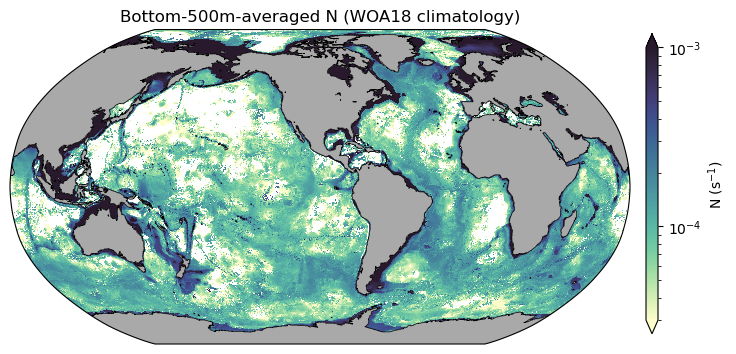

In [12]:
fig = plt.figure(figsize=(8, 6))
ax1 = plt.axes(projection=ccrs.Robinson(central_longitude=-100))

# Add model land mask
land = xr.where(np.isnan(t_an[0,:,:].rename('land')), 1, np.nan)
land.plot.contourf(ax=ax1, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
# Add model coastline
land.fillna(0).plot.contour(ax=ax1, colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)
#ax1.plot(lon[xind].values,lat[yind].values,'*',color='r',transform=ccrs.PlateCarree())

p1 = ax1.pcolormesh(lon, lat, N_3D_b5_ave, transform=ccrs.PlateCarree(), cmap=cm.cm.deep, norm=LogNorm(vmin=3e-5, vmax=1e-3))
plt.title('Bottom-500m-averaged N (WOA18 climatology)')

ax1_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb1 = plt.colorbar(p1, cax=ax1_cb, orientation='vertical', extend='both')
cb1.ax.set_ylabel('N (s$^{-1}$)');

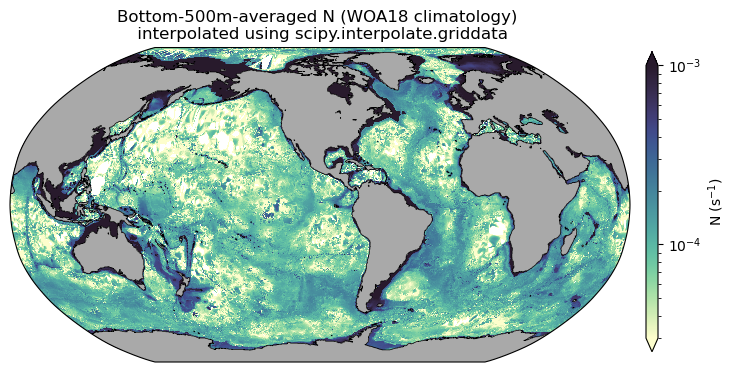

In [13]:
fig = plt.figure(figsize=(8, 6))
ax1 = plt.axes(projection=ccrs.Robinson(central_longitude=-100))

# Add model land mask
land = xr.where(np.isnan(t_an[0,:,:].rename('land')), 1, np.nan)
land.plot.contourf(ax=ax1, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
# Add model coastline
land.fillna(0).plot.contour(ax=ax1, colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)

p1 = ax1.pcolormesh(lon, lat, N_3D_b5_array_filled, transform=ccrs.PlateCarree(), cmap=cm.cm.deep, norm=LogNorm(vmin=3e-5, vmax=1e-3))
plt.title('Bottom-500m-averaged N (WOA18 climatology) \n interpolated using scipy.interpolate.griddata')

ax1_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb1 = plt.colorbar(p1, cax=ax1_cb, orientation='vertical', extend='both')
cb1.ax.set_ylabel('N (s$^{-1}$)');

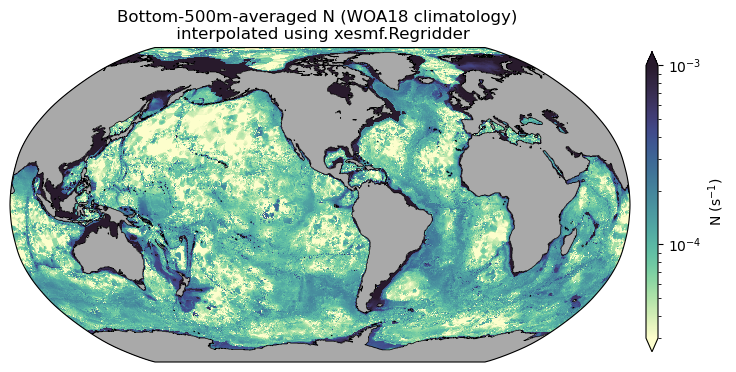

In [14]:
fig = plt.figure(figsize=(8, 6))
ax1 = plt.axes(projection=ccrs.Robinson(central_longitude=-100))

# Add model land mask
land.plot.contourf(ax=ax1, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
# Add model coastline
land.fillna(0).plot.contour(ax=ax1, colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)

p1 = ax1.pcolormesh(lon, lat, ds_out['N_3D_b5_ave'], transform=ccrs.PlateCarree(), cmap=cm.cm.deep, norm=LogNorm(vmin=3e-5, vmax=1e-3))
plt.title('Bottom-500m-averaged N (WOA18 climatology) \n interpolated using xesmf.Regridder')

ax1_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb1 = plt.colorbar(p1, cax=ax1_cb, orientation='vertical', extend='both')
cb1.ax.set_ylabel('N (s$^{-1}$)');

## Save the bottom-500m-averaged N

Create a DataSet and include the DataArray N_3D_b5_ave

In [15]:
Nbot_data = xr.Dataset({'Nbot': (('lat','lon'), np.array(ds_out['N_3D_b5_ave']))}, 
                       coords={'lon':lon,'lat':lat})
Nbot_data.to_netcdf('/g/data/nm03/lxy581/WOA18/Nbot_1000m_woa18.nc')